In [ ]:
import hazm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from hazm import word_tokenize
from hazm import Stemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [32]:
sns.set_style('darkgrid')

In [2]:
data = pd.read_csv('digikala-comments.csv', nrows=10000) 

In [74]:
data.head()

,id,title,body,created_at,rate,recommendation_status,is_buyer,product_id,advantages,disadvantages,likes,dislikes,seller_title,seller_code,true_to_size_rate
0,53672599,پیشنهاد نمیشود,به درد نمیخوره,23 شهریور 1402,1.0,not_recommended,True,252058,NaN,NaN,0,0,دیجی‌کالا,5A52N,NaN
1,9897229,بسته بندی بد,می‌تونست به عنوان یه کالای فرهنگی بهتر بسته بن...,16 تیر 1399,0.0,recommended,True,252058,['تجربه جالبی بود برام '],['بسته بندی جالبی نداشت'],1,0,دیجی‌کالا,5A52N,NaN
2,38074516,برس ریمل,بسته بندیش خوب بود\r\n کاربرد و کیفیتشم خیلی خ...,26 مرداد 1401,0.0,recommended,True,3331597,NaN,NaN,0,0,آرالیا بیوتی,ADM47,NaN
3,18628562,خوبه و خوشرنگ,به نظرم خوبه فقط یکم ظریفه. از رنگش خوشم اومد ...,28 اسفند 1399,0.0,recommended,True,3331329,NaN,NaN,0,0,اینجاست آ,9ZMCZ,NaN
4,53301258,برس رنگ مو,معمولیه اگه واسه خونه رنگ کردن شخصی میخواین او...,12 شهریور 1402,3.0,recommended,True,3255700,NaN,NaN,0,0,گالری آرایشی به سیما,CDWHA,NaN


In [4]:
data.recommendation_status.value_counts()

recommendation_status
recommended        6811
no_idea             978
not_recommended     757
Name: count, dtype: int64

In [5]:
data[['title', 'body', 'recommendation_status']].dtypes

title                    object
body                     object
recommendation_status    object
dtype: object

In [6]:
data.isnull().sum()

id                          0
title                    4731
body                        2
created_at                  0
rate                        0
recommendation_status    1454
is_buyer                    0
product_id                  0
advantages               8673
disadvantages            9268
likes                       0
dislikes                    0
seller_title              472
seller_code               472
true_to_size_rate        9944
dtype: int64

In [7]:
data['title'] = data['title'].fillna('')
data['body'] = data['body'].fillna('')
data = data.dropna(subset=['recommendation_status'])

In [8]:
with open('stopwords.txt') as stopwords_file:
    lines = stopwords_file.readlines()
    stop_words = []
    for line in lines:
        stop_words.append(line.replace('\n', '').strip())

In [ ]:
# stemmer = hazm.Stemmer()
# datasets = pd.DataFrame(columns=('title_body', 'recommendation_status'))
# for index, row in data.iterrows():
#     title_body = row['title'] + ' ' + row['body']
#     title_body_tokenized = word_tokenize(title_body)
#     title_body_tokenized_filtered = []
#     for s in title_body_tokenized:
#         if s not in stop_words:
#             title_body_tokenized_filtered.append(s)
#     title_body_tokenized_filtered_stemmed = []
#     for w in title_body_tokenized_filtered:
#         title_body_tokenized_filtered_stemmed.append(stemmer.stem(w))
#     datasets.loc[index] = {
#         'title_body' : ' '.join(title_body_tokenized_filtered_stemmed),
#         'recommendation_status' : row['recommendation_status'] 
#     }

In [11]:
stemmer = hazm.Stemmer()
processed_rows = []
for index, row in data.iterrows():
    title_body = row['title'] + ' ' + row['body']
    tokens = [t for t in word_tokenize(title_body) if t not in stop_words]
    stemmed_tokens = [stemmer.stem(w) for w in tokens]
    processed_rows.append({
        'title_body': ' '.join(stemmed_tokens),
        'recommendation_status': row['recommendation_status']
    })

datasets = pd.DataFrame(processed_rows)
datasets

,title_body,recommendation_status
0,پیشنهاد نمیشود درد نمیخوره,not_recommended
1,بسته می‌تونس کالا فرهنگ بسته بشه,recommended
2,برس ریمل بسته بند بود\r کاربرد کیفیت خوبه روغن...,recommended
3,خوبه خوشرنگ نظر خوبه یک ظریفه رنگ خو اومد صابو...,recommended
4,برس رنگ مو معمولیه واسه خونه رنگ شخص میخواین ا...,recommended
...,...,...
8541,معمولیه,recommended
8542,عال عال,recommended
8543,نظر عال,recommended
8544,عال خرید شد راض,recommended


In [12]:
datasets.isnull().sum()

title_body               0
recommendation_status    0
dtype: int64

In [13]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(datasets.title_body)
X

<8546x97636 sparse matrix of type '<class 'numpy.float64'>'
	with 170262 stored elements in Compressed Sparse Row format>

In [14]:
le = LabelEncoder()
y = le.fit_transform(datasets.recommendation_status)
y

array([1, 2, 2, ..., 2, 2, 1])

In [16]:
print(le.classes_)
print(np.unique(y, return_counts=True))

['no_idea' 'not_recommended' 'recommended']
(array([0, 1, 2]), array([ 978,  757, 6811]))


In [19]:
datasets.groupby('recommendation_status')['title_body'].count() / len(datasets)

recommendation_status
no_idea            0.114440
not_recommended    0.088579
recommended        0.796981
Name: title_body, dtype: float64

<Axes: xlabel='recommendation_status', ylabel='count'>

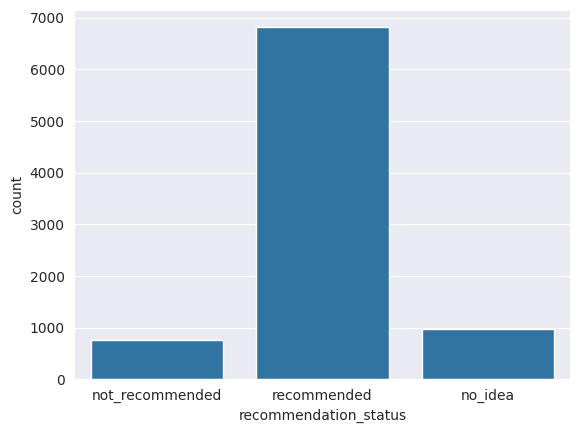

In [20]:
sns.set_style('darkgrid')
sns.countplot(datasets, x='recommendation_status')

In [21]:
ros = RandomOverSampler(random_state=12)
X_ros, y_ros = ros.fit_resample(X, y)

In [22]:
print(np.unique(y_ros, return_counts=True))

(array([0, 1, 2]), array([6811, 6811, 6811]))


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, random_state=32)

In [24]:
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))

(15324, 97636)
(5109, 97636)
(15324,)
(5109,)


In [25]:
svmc = SVC()
svmc.fit(X_train, y_train)

SVC()

In [26]:
svmc.score(X_test, y_test) * 100

95.16539440203562

In [27]:
y_pred = svmc.predict(X_test)

In [38]:
print(classification_report(y_test, y_pred, target_names=le.classes_))

                 precision    recall  f1-score   support

        no_idea       0.92      0.95      0.94      1727
not_recommended       0.98      0.97      0.97      1661
    recommended       0.96      0.94      0.95      1721

       accuracy                           0.95      5109
      macro avg       0.95      0.95      0.95      5109
   weighted avg       0.95      0.95      0.95      5109



<Axes: >

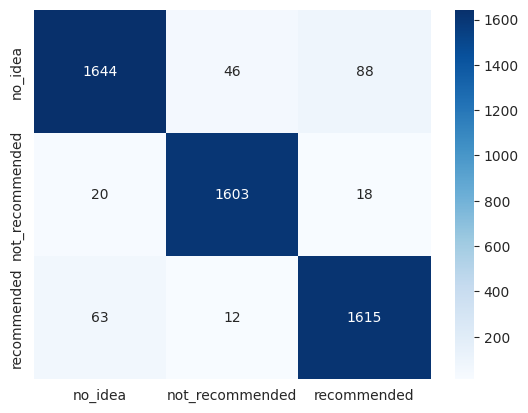

In [39]:
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)

In [51]:
sample_comments = [
    'کیفیتش خیلی بد بود اصلا پیشنهاد نمیکنم',
    ' محصول به موقع رسید و بسته‌بندی عالی بود، راضی ام',
    'باتری بعد از دو روز خراب شد، اصلا نمی‌ارزه',
    'قیمت مناسبه و کیفیت هم خوب',
    'خیلی بد بود',
    'مامان خرید راضی بود'
]

processed_comments = []
for comment in sample_comments:
    tokens = word_tokenize(comment)
    filtered_tokens = [stemmer.stem(w) for w in tokens if w not in stop_words]
    processed_comments.append(" ".join(filtered_tokens))

X_new = vectorizer.transform(processed_comments)
predictions = le.inverse_transform(svmc.predict(X_new))

for text, pred in zip(sample_comments, predictions):
    print(f"comment: {text} => model prediction : {pred}")


comment: کیفیتش خیلی بد بود اصلا پیشنهاد نمیکنم => model prediction : not_recommended
comment:  محصول به موقع رسید و بسته‌بندی عالی بود، راضی ام => model prediction : recommended
comment: باتری بعد از دو روز خراب شد، اصلا نمی‌ارزه => model prediction : recommended
comment: قیمت مناسبه و کیفیت هم خوب => model prediction : recommended
comment: خیلی بد بود => model prediction : no_idea
comment: مامان خرید راضی بود => model prediction : recommended


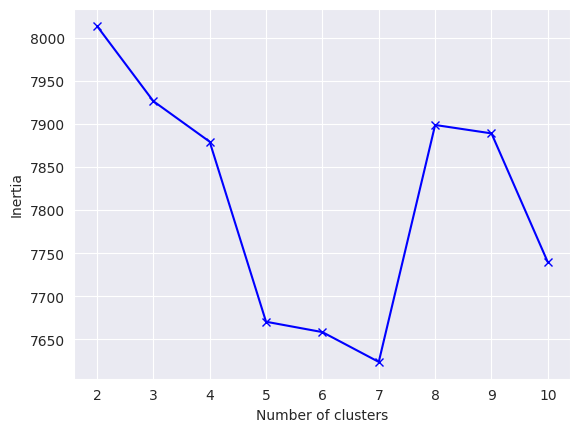

In [54]:
inertia = []
K = range(2,11)
for k in K:
    km = KMeans(n_clusters=k, random_state=32)
    km.fit(X)
    inertia.append(km.inertia_)
plt.plot(K, inertia, 'bx-')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

In [55]:
k = 5  
kmeans = KMeans(n_clusters=k, random_state=32)
clusters = kmeans.fit_predict(X)
datasets['cluster'] = clusters


In [56]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(k):
    print(f"Cluster {i}:")
    print([terms[ind] for ind in order_centroids[i, :10]])

Cluster 0:
['راض', 'خوبه راض', 'عال راض', 'خوبه', 'خرید راض', 'عال', 'خرید', 'راض خوبه', 'راض راض', 'راض خرید راض']
Cluster 1:
['خوبه', 'خوبه خوبه', 'خوبه خوبه خوبه', '۹۹ کتابا پرتقال', 'داره دوماهه صابون', 'داره دوتا پال', 'داره دور', 'داره دور قاعدگ', 'داره دوستتون', 'داره دوستتون سازگار']
Cluster 2:
['خوبه', 'عال', 'عالیه', 'بو', 'مو', 'راض', 'داره', 'شامپو', 'خوب', 'کتاب']
Cluster 3:
['کیف', 'مناسب', 'قیم', 'قیم مناسب', 'کیف مناسب', 'عال', 'نسب قیم', 'نسب', 'کیف عال', 'کیف خوب']
Cluster 4:
['عال', 'عال عال', 'عال عال عال', 'داره راض', 'داره راص', 'داره دور قاعدگ', 'داره دوستتون', 'داره راض باز', 'داره دوستتون سازگار', 'داره دوسه']


In [ ]:
positive_texts = datasets[datasets['recommendation_status']=='recommended']['title_body']
negative_texts = datasets[datasets['recommendation_status']=='not_recommended']['title_body']
neutral_texts  = datasets[datasets['recommendation_status']=='no_idea']['title_body']